# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu.


## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Summary 
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78701?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78753?</a></li>     
><li><a href="#q4"> 4. How is crime distributed in 78741?</a></li>
><li><a href="#q5"> 5. How is crime distributed in 78745?</a></li>
><li><a href="#q6"> 6. How is crime distributed in 78705?</a></li>
><li><a href="#q7"> 7. How are violent crimes, in particular murder, capital murder, armed robbery, aggrivated assault, and rape distributed?
><li><a href="#q8"> 8. How is crime distributed across different districts and sectors around Austin? Location types?
><li><a href="#q9"> 9. How does violent crime appear on the map?
><li><a href="#q10"> 10. Are there any addresses where violent crime and murder occurs frequently?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I first attempted importing the data into this notebook using Sodapy's Socrata API method but found it lacking. It didn't import the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# importing necessary libraries and configurations
import folium
from folium import plugins
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

plt.style.use("classic")
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# loading the data
df = pd.read_csv("Datasets\crime_reports.csv")

In [3]:
# examining the dataframe
print(df.info())
print(df.isnull().sum())
print(df.head())
print(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296688 entries, 0 to 2296687
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Incident Number              int64  
 1   Highest Offense Description  object 
 2   Highest Offense Code         int64  
 3   Family Violence              object 
 4   Occurred Date Time           object 
 5   Occurred Date                object 
 6   Occurred Time                float64
 7   Report Date Time             object 
 8   Report Date                  object 
 9   Report Time                  float64
 10  Location Type                object 
 11  Address                      object 
 12  Zip Code                     float64
 13  Council District             float64
 14  APD Sector                   object 
 15  APD District                 object 
 16  PRA                          object 
 17  Census Tract                 float64
 18  Clearance Status             object 
 19  

## II. Data Prep

There are several columns we don't need which we'll drop. We'll index the data according to the OCCURRED DATE TIME column. The following code creates a reproducible script for scrubbing and parsing the data.

In [4]:
def clean_data(df):
    drop_col = [
        "Incident Number",
        "Occurred Time",
        "Occurred Date Time",
        "Highest Offense Code",
        "Census Tract",
        "PRA",
        "Report Date",
        "Report Time",
        "UCR Category",
        "Category Description",
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    df.drop(drop_col, axis=1, inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    df.replace(" ", np.nan, inplace=True)
    date_col = ["occurred_date", "report_date_time", "clearance_date"]
    cat_col = [
        "highest_offense_description",
        "zip_code",
        "location_type",
        "council_district",
        "apd_district",
        "apd_sector",
    ]
    df[date_col] = df[date_col].astype("datetime64")
    df[cat_col] = df[cat_col].astype("category")
    df["year"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.year
    df["month"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.month
    df["week"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.week
    df["day"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.day
    df.set_index(["occurred_date"], inplace=True)
    df.sort_index(inplace=True)
    return df


df = clean_data(df)

In [5]:
# reexamining the dataframe
print(df.info())
print(df.index)
print(df.isnull().sum())
print(df.head())
print(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2296688 entries, 2003-01-01 to 2020-12-26
Data columns (total 17 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   highest_offense_description  category      
 1   family_violence              object        
 2   report_date_time             datetime64[ns]
 3   location_type                category      
 4   address                      object        
 5   zip_code                     category      
 6   council_district             category      
 7   apd_sector                   category      
 8   apd_district                 category      
 9   clearance_status             object        
 10  clearance_date               datetime64[ns]
 11  latitude                     float64       
 12  longitude                    float64       
 13  year                         int64         
 14  month                        int64         
 15  week                         int64

## III. Exploratory Analysis

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

78741.0    206377
78753.0    178516
78701.0    168161
78758.0    158877
78704.0    154323
78745.0    150513
78702.0    136578
78744.0    126048
78723.0    118156
78752.0     84294
78748.0     67948
78759.0     66177
78751.0     63954
78757.0     57756
78705.0     56980
78721.0     47625
78749.0     40343
78724.0     37590
78727.0     35789
78703.0     35126
78731.0     28588
78746.0     28081
78729.0     25249
78750.0     23643
78754.0     22754
Name: zip_code, dtype: int64
78741.0    0.090414
78753.0    0.078208
78701.0    0.073671
78758.0    0.069604
78704.0    0.067609
78745.0    0.065940
78702.0    0.059835
78744.0    0.055222
78723.0    0.051764
78752.0    0.036929
78748.0    0.029768
78759.0    0.028992
78751.0    0.028018
78757.0    0.025303
78705.0    0.024963
78721.0    0.020865
78749.0    0.017674
78724.0    0.016468
78727.0    0.015679
78703.0    0.015389
78731.0    0.012524
78746.0    0.012302
78729.0    0.011062
78750.0    0.010358
78754.0    0.009969
Name: zip_code, dtype

<AxesSubplot:title={'center':'Top 25 zip codes, overall crime (2003-present)'}>

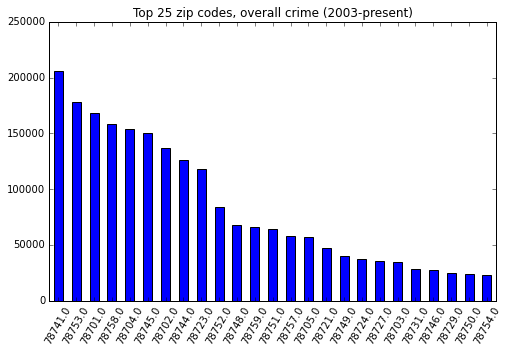

In [6]:
# Create and show dataframe for crime rates by zipcode and as percentages
print(df.zip_code.value_counts().head(25))
print(df.zip_code.value_counts(normalize=True).head(25))

# Visualizing the top 25 areas for crime
df.zip_code.value_counts().head(25).plot.bar(
    rot=60, title="Top 25 zip codes, overall crime (2003-present)", figsize=(8, 5)
)

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78701 (downtown Austin)? 

PUBLIC INTOXICATION               17150
THEFT                             15738
BURGLARY OF VEHICLE                9247
WARRANT ARREST NON TRAFFIC         8967
DWI                                8308
ASSAULT WITH INJURY                7497
VIOL CITY ORDINANCE - OTHER        6188
POSS OF DRUG PARAPHERNALIA         6029
CRIMINAL MISCHIEF                  5793
CRIMINAL TRESPASS                  3902
POSSESSION OF MARIJUANA            3379
DISTURBANCE - OTHER                3343
CUSTODY ARREST TRAFFIC WARR        3001
POSS CONTROLLED SUB/NARCOTIC       2893
CAMPING IN PARK                    2791
VOCO - ALCOHOL  CONSUMPTION        2690
CRIMINAL TRESPASS/TRANSIENT        2578
ASSAULT BY CONTACT                 2569
THEFT OF BICYCLE                   2501
URINATING IN PUBLIC PLACE          2336
FAMILY DISTURBANCE                 2141
DOC FIGHTING                       2107
PROTECTIVE ORDER                   2101
ASSAULT W/INJURY-FAM/DATE VIOL     1724
Name: highest_offense_description, dtype

<AxesSubplot:title={'center':'Crime Distribution (78701)'}, ylabel='highest_offense_description'>

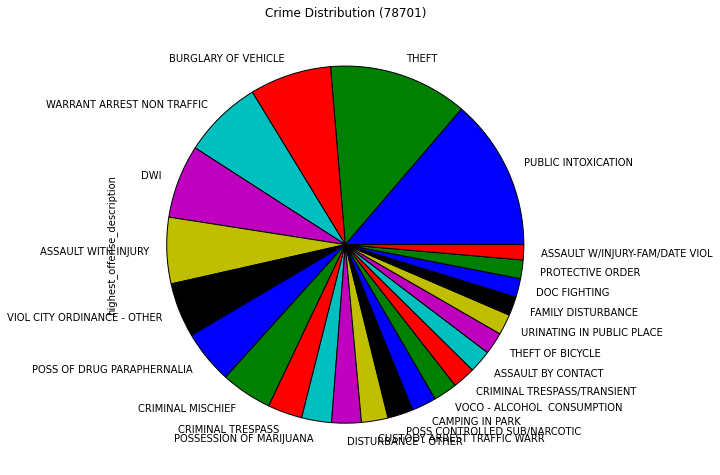

In [7]:
# Examining crime in the 78701 area
df_01 = df[df.zip_code == 78701]

# Create a dataframe for the top crime categories in the zipcode
df_01_off = df_01.highest_offense_description.value_counts().head(24)

# Display the different crime values & then as percentages
print(df_01_off)
print(df_01.highest_offense_description.value_counts(normalize=True).head(24))
df_01_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78701)")

<a id='q3'></a>
### C. Question 2. How is crime distributed in 78753? 

THEFT                             17101
BURGLARY OF VEHICLE               15932
FAMILY DISTURBANCE                14598
CRIMINAL MISCHIEF                  9442
THEFT BY SHOPLIFTING               7622
ASSAULT W/INJURY-FAM/DATE VIOL     7126
BURGLARY OF RESIDENCE              6055
DWI                                4983
DISTURBANCE - OTHER                4742
CUSTODY ARREST TRAFFIC WARR        4343
HARASSMENT                         4235
AUTO THEFT                         4192
POSS OF DRUG PARAPHERNALIA         3721
PUBLIC INTOXICATION                3363
ASSAULT WITH INJURY                3296
CRIMINAL TRESPASS                  3132
POSS CONTROLLED SUB/NARCOTIC       2971
RUNAWAY CHILD                      2923
WARRANT ARREST NON TRAFFIC         2794
POSSESSION OF MARIJUANA            2698
BURGLARY NON RESIDENCE             2492
VIOL CITY ORDINANCE - OTHER        1866
Name: highest_offense_description, dtype: int64
----------------------------------
THEFT                             0.0

<AxesSubplot:title={'center':'Crime Distribution (78753)'}, ylabel='highest_offense_description'>

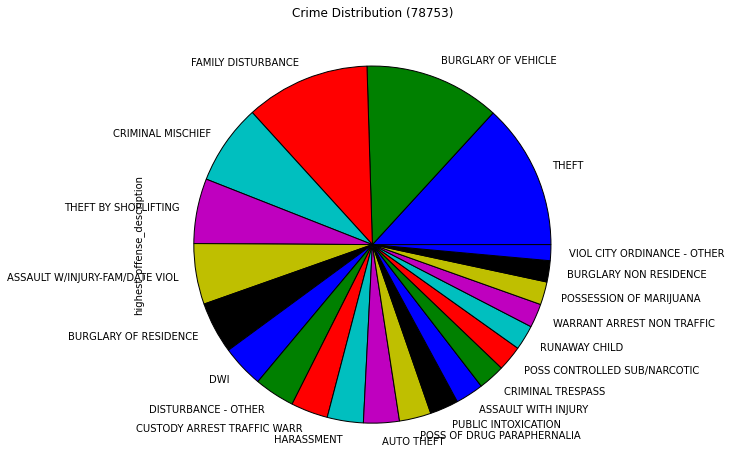

In [8]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
print(df_53_off)
print("----------------------------------")
print(df_53.highest_offense_description.value_counts(normalize=True).head(22))
df_53_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78753)")

<a id='q4'></a>
### D. Question 4. How is crime distributed in 78741 (E Riverside/Oltorf)? 

FAMILY DISTURBANCE                20282
BURGLARY OF VEHICLE               19782
THEFT                             15566
CRIMINAL MISCHIEF                 11015
ASSAULT W/INJURY-FAM/DATE VIOL     9603
BURGLARY OF RESIDENCE              8868
PUBLIC INTOXICATION                6378
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5647
HARASSMENT                         5493
DISTURBANCE - OTHER                5151
AUTO THEFT                         4602
ASSAULT WITH INJURY                4524
CRIMINAL TRESPASS                  3903
POSS CONTROLLED SUB/NARCOTIC       3850
POSSESSION OF MARIJUANA            3792
THEFT BY SHOPLIFTING               3574
POSS OF DRUG PARAPHERNALIA         3533
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2787
VIOL CITY ORDINANCE - OTHER        2196
Name: highest_offense_description, dtype: int64
----------------------------------
FAMILY DISTURBANCE                0.098276
BURGLARY OF VEHICLE               

<AxesSubplot:title={'center':'Crime Distribution (78741)'}, ylabel='highest_offense_description'>

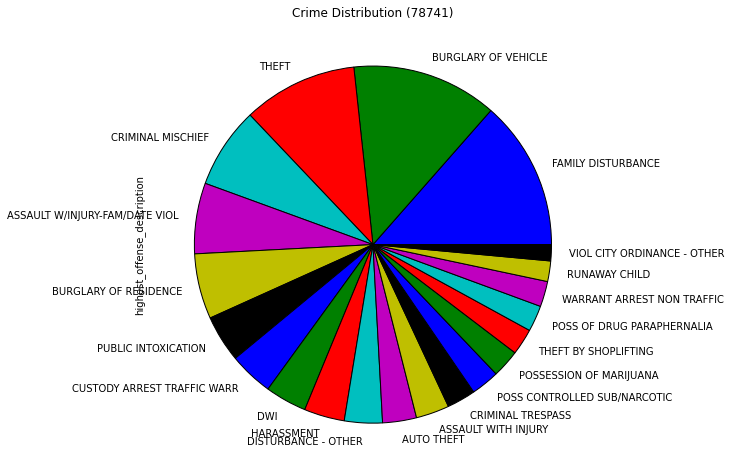

In [9]:
# Examining crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages
print(df_41_off)
print("----------------------------------")
print(df_41.highest_offense_description.value_counts(normalize=True).head(21))
df_41_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78741)")

<a id='q5'></a>
### E. Question 5. How is crime distributed in 78745 (far south Austin)?

FAMILY DISTURBANCE                14871
BURGLARY OF VEHICLE               14751
THEFT                             13529
CRIMINAL MISCHIEF                  8489
BURGLARY OF RESIDENCE              5867
ASSAULT W/INJURY-FAM/DATE VIOL     5740
HARASSMENT                         5125
DISTURBANCE - OTHER                4500
DWI                                4410
PUBLIC INTOXICATION                3994
CUSTODY ARREST TRAFFIC WARR        3248
BURGLARY NON RESIDENCE             2916
AUTO THEFT                         2841
ASSAULT WITH INJURY                2660
RUNAWAY CHILD                      2594
POSSESSION OF MARIJUANA            2586
WARRANT ARREST NON TRAFFIC         2108
POSS CONTROLLED SUB/NARCOTIC       2012
THEFT BY SHOPLIFTING               1972
CRIMINAL TRESPASS                  1946
IDENTITY THEFT                     1570
POSS OF DRUG PARAPHERNALIA         1515
Name: highest_offense_description, dtype: int64
----------------------------------
FAMILY DISTURBANCE                0.0

<AxesSubplot:title={'center':'Crime Distribution (78745)'}, ylabel='highest_offense_description'>

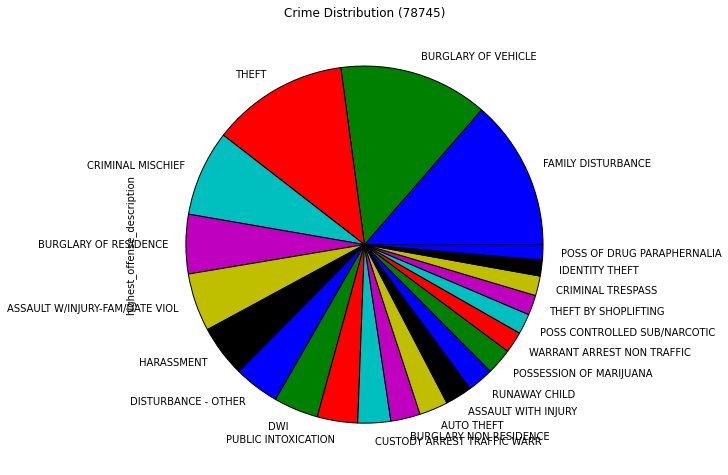

In [10]:
# Examining crime in the 78745 area
df_45 = df[df.zip_code == 78745]

# Create a dataframe for the top 10 crime categories in the zipcode
df_45_off = df_45.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
print(df_45_off)
print("----------------------------------")
print(df_45.highest_offense_description.value_counts(normalize=True).head(22))
df_45_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78745)")

<a id='q6'></a>
### F. Question 6. How is crime distributed in 78705 (UT campus area)?

BURGLARY OF VEHICLE               8609
THEFT                             5592
CRIMINAL MISCHIEF                 4955
THEFT OF BICYCLE                  3467
PUBLIC INTOXICATION               2626
BURGLARY OF RESIDENCE             2116
WARRANT ARREST NON TRAFFIC        1548
CRIMINAL TRESPASS                 1341
AUTO THEFT                        1302
ASSAULT WITH INJURY               1244
DWI                               1218
HARASSMENT                        1211
FAMILY DISTURBANCE                1180
DISTURBANCE - OTHER               1113
BURGLARY NON RESIDENCE             873
CRIMINAL TRESPASS/TRANSIENT        868
VIOL CITY ORDINANCE - OTHER        791
CUSTODY ARREST TRAFFIC WARR        783
GRAFFITI                           776
ASSAULT W/INJURY-FAM/DATE VIOL     689
POSSESSION OF MARIJUANA            657
ASSAULT BY CONTACT                 613
Name: highest_offense_description, dtype: int64
----------------------------------
BURGLARY OF VEHICLE               0.151088
THEFT           

<AxesSubplot:title={'center':'Crime Distribution (78705)'}, ylabel='highest_offense_description'>

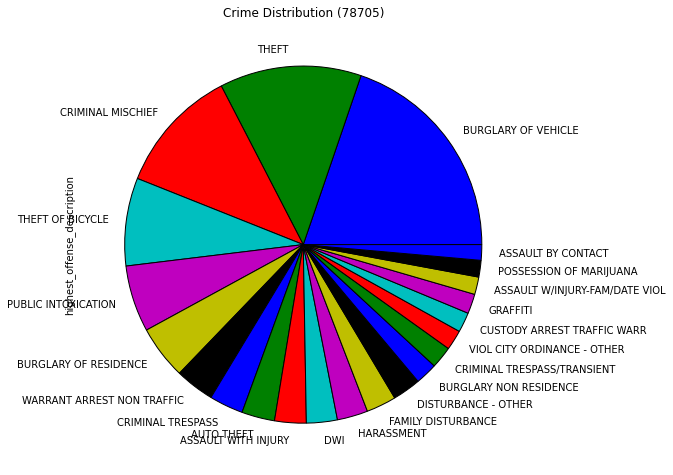

In [11]:
# Examining crime in the 78705 area
df_05 = df[df.zip_code == 78705]

# Create a dataframe for the top 10 crime categories in the zipcode
df_05_off = df_05.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
print(df_05_off)
print("----------------------------------")
print(df_05.highest_offense_description.value_counts(normalize=True).head(22))
df_05_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78705)")

<a id='q7'></a>
### H. Question 7. How are violent crimes, in particular murder, capital murder, armed robbery, aggrivated assault, and rape distributed? 

In [12]:
# Creating separate dataframes for overall & violent crime
df_viol = df.query(
    'highest_offense_description == ["AGG ASSAULT", "AGG ROBBERY/DEADLY WEAPON", "CAPITAL MURDER", "MURDER", "RAPE"]'
)
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_agg_asslt = df[df.highest_offense_description == "AGG ASSAULT"]
df_agg_robbery = df[df.highest_offense_description == "AGG ROBBERY/DEADLY WEAPON"]

# Creating yearly dataframes
# Annual overall crime
df_17 = df[df.year == 2017]
df_18 = df[df.year == 2018]
df_19 = df[df.year == 2019]
df_20 = df[df.year == 2020]

# Annual violent crime
df_viol_17 = df_viol[df_viol.year == 2017]
df_viol_18 = df_viol[df_viol.year == 2018]
df_viol_19 = df_viol[df_viol.year == 2019]
df_viol_20 = df_viol[df_viol.year == 2020]

# Annual murders
df_viol_mur_17 = df_viol_mur[df_viol_mur.year == 2017]
df_viol_mur_18 = df_viol_mur[df_viol_mur.year == 2018]
df_viol_mur_19 = df_viol_mur[df_viol_mur.year == 2019]
df_viol_mur_20 = df_viol_mur[df_viol_mur.year == 2020]

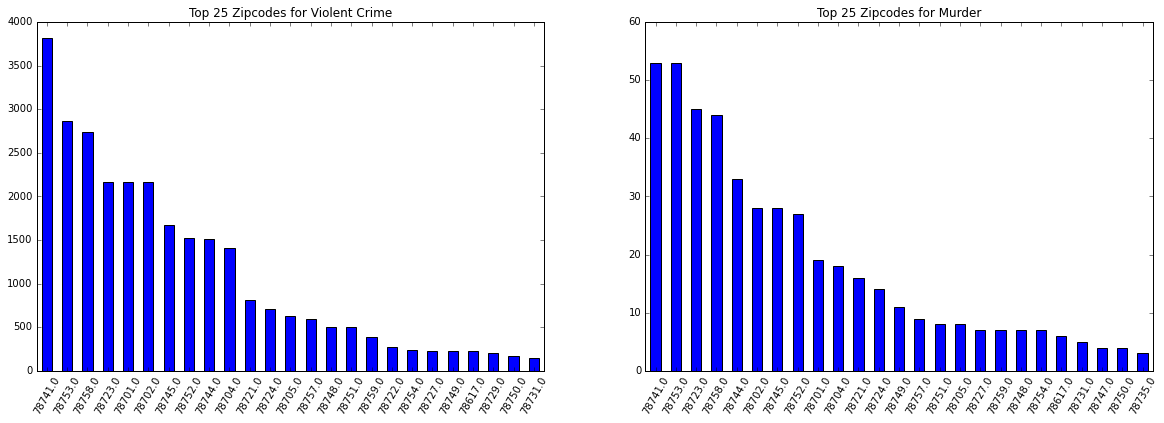

highest_offense_description  AGG ASSAULT  AGG ROBBERY/DEADLY WEAPON  \
zip_code                                                              
78610.0                                1                          0   
78613.0                               14                         11   
78617.0                              121                         62   
78621.0                                1                          0   
78634.0                                1                          0   
78652.0                                2                          0   
78653.0                               10                          3   
78660.0                               65                         28   
78664.0                                3                          0   
78681.0                                1                          0   
78701.0                             1497                        293   
78702.0                             1206                        743   
78703.

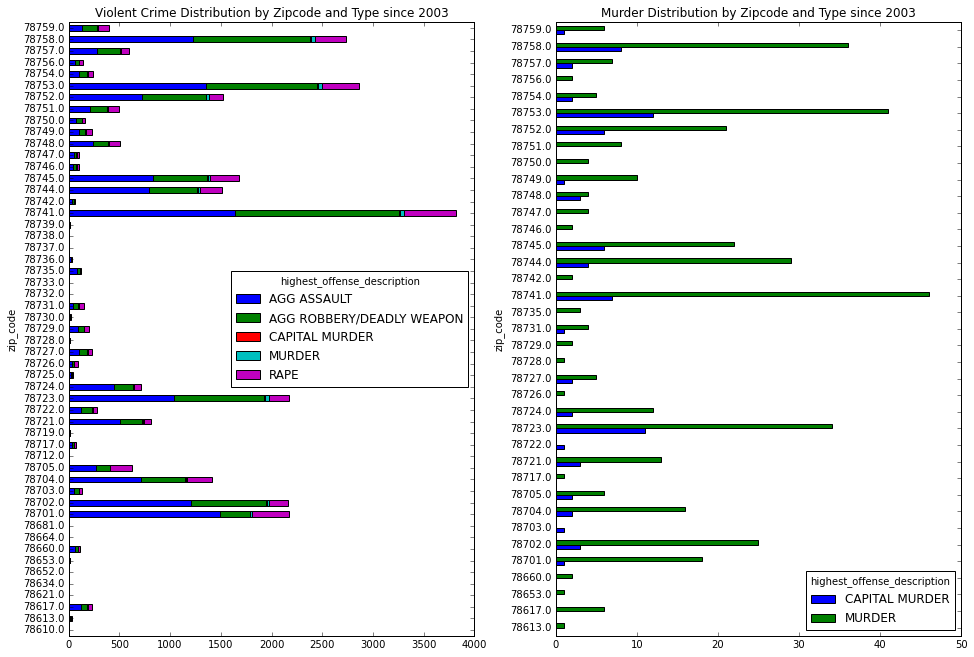

In [13]:
fig, axs = plt.subplots(figsize=(20, 6.25), ncols=2)
df_viol.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 Zipcodes for Violent Crime", rot=60, ax=axs[0]
)
df_viol_mur.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 Zipcodes for Murder", rot=60, ax=axs[1]
)
plt.show()

viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)
mur_freq = pd.crosstab(df_viol_mur.zip_code, df_viol_mur.highest_offense_description)
print(viol_freq)

fig, axs = plt.subplots(figsize=(16, 11), ncols=2)
viol_freq.plot.barh(
    title="Violent Crime Distribution by Zipcode and Type since 2003",
    ax=axs[0],
    stacked=True,
)
mur_freq.plot.barh(
    title="Murder Distribution by Zipcode and Type since 2003", ax=axs[1]
)
plt.show()

#### Distribution of violent crime and murders across council districts, APD Districts, and APD sectors 

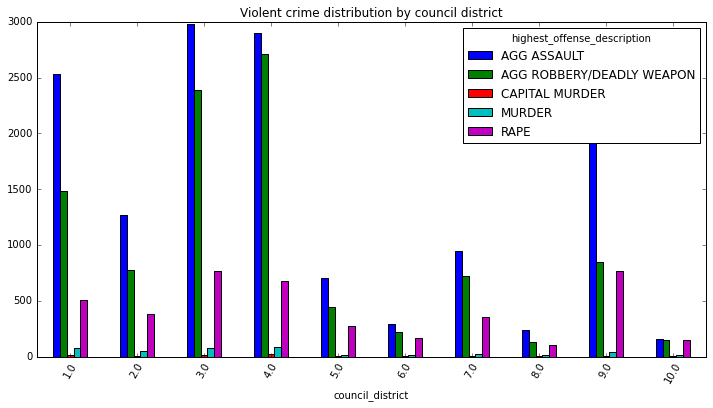

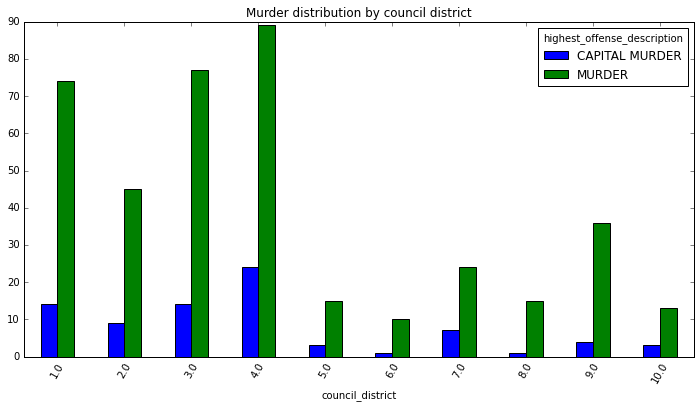

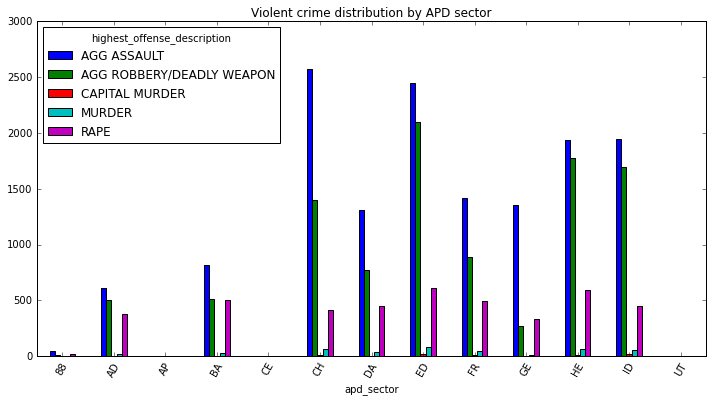

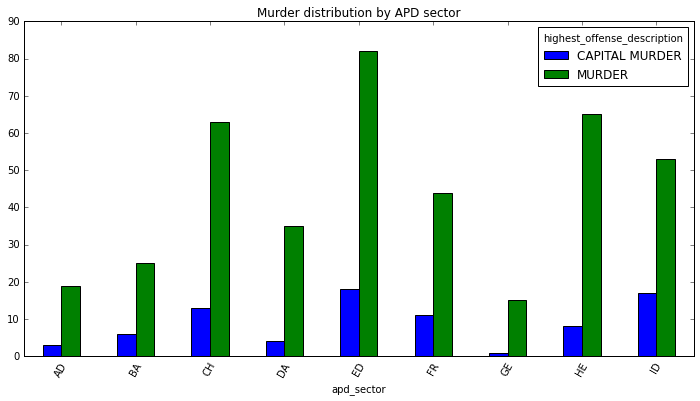

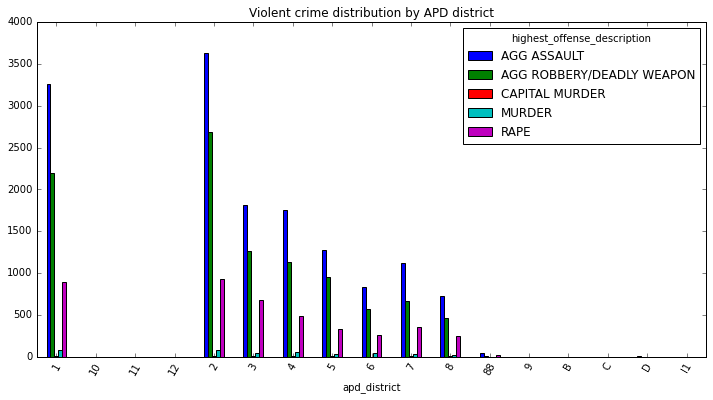

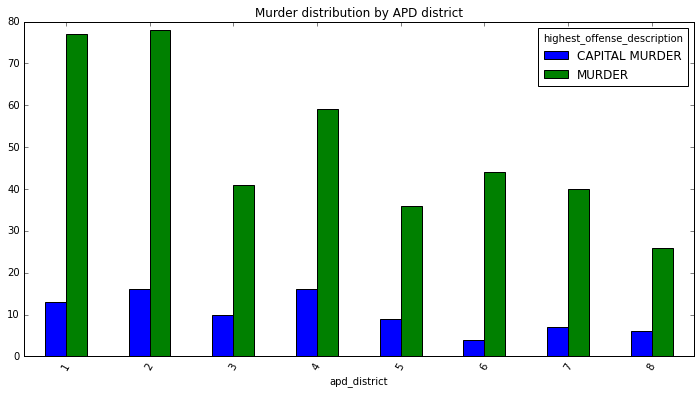

In [14]:
pd.crosstab(df_viol.council_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by council district"
)
plt.show()

pd.crosstab(
    df_viol_mur.council_district, df_viol_mur.highest_offense_description
).plot.bar(figsize=(12, 6), rot=60, title="Murder distribution by council district")
plt.show()

pd.crosstab(df_viol.apd_sector, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by APD sector"
)
plt.show()

pd.crosstab(df_viol_mur.apd_sector, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Murder distribution by APD sector"
)
plt.show()

pd.crosstab(df_viol.apd_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by APD district"
)
plt.show()

pd.crosstab(df_viol_mur.apd_district, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Murder distribution by APD district"
)
plt.show()

#### Violent crime and murder distribution by location type

highest_offense_description                     AGG ASSAULT  \
location_type                                                 
ABANDONED/CONDEMNED STRUCTURE                            13   
AMUSEMENT PARK                                            0   
ARENA / STADIUM / FAIRGROUNDS / COLISEUM                  2   
ATM SEPARATE FROM BANK                                    1   
AUTO DEALERSHIP NEW / USED                               10   
BANKS / SAVINGS & LOAN                                    5   
BAR / NIGHT CLUB                                        653   
CAMP / CAMPGROUND                                        20   
CHURCH / SYNAGOGUE / TEMPLE / MOSQUE                     20   
COMMERCIAL / OFFICE BUILDING                            269   
COMMUNITY CENTER                                          9   
CONSTRUCTION SITE                                        30   
CONVENIENCE STORE                                       227   
DAYCARE FACILITY                                       

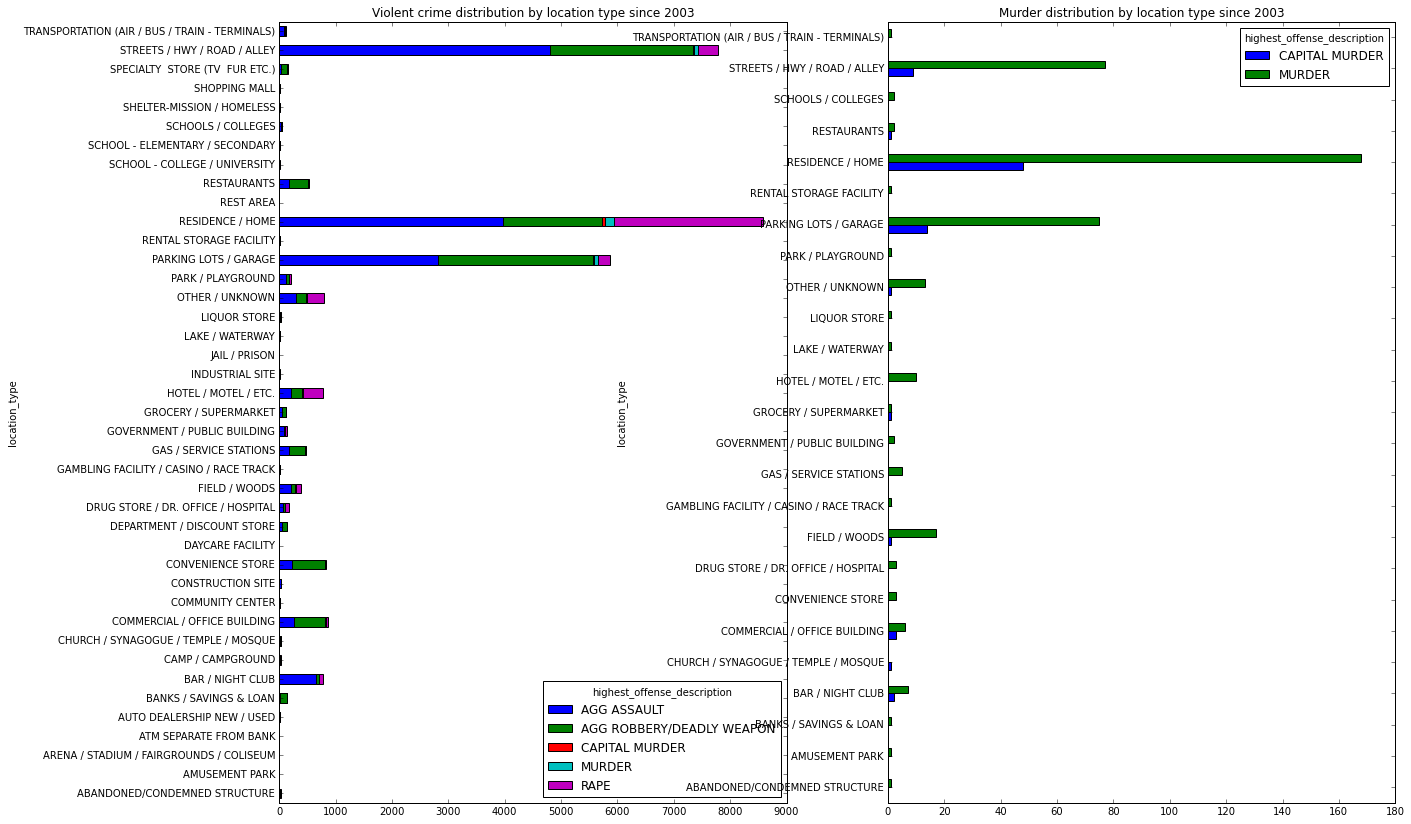

In [15]:
viol_loc = pd.crosstab(df_viol.location_type, df_viol.highest_offense_description)
print(viol_loc)
mur_loc = pd.crosstab(
    df_viol_mur.location_type, df_viol_mur.highest_offense_description
)

fig, axs = plt.subplots(figsize=(20, 14), ncols=2)
viol_loc.plot.barh(
    title="Violent crime distribution by location type since 2003",
    ax=axs[0],
    stacked=True,
)
mur_loc.plot.barh(title="Murder distribution by location type since 2003", ax=axs[1])
plt.show()

<a id='q9'></a>
### I. Question 9. How does violent crime appear on the map?

** Note: Rape incidents provide no location coordinates therefore cannot be shown on a map. **

#### Aggravated assault 

In [16]:
agg_asslt_coords_heat = df_agg_asslt[
    (df_agg_asslt["latitude"].isnull() == False)
    & (df_agg_asslt["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(agg_asslt_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="agg_asslt_heatmap.html")

k

#### Armed robbery 

In [17]:
agg_robbery_coords_heat = df_agg_robbery[
    (df_agg_robbery["latitude"].isnull() == False)
    & (df_agg_robbery["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(
        agg_robbery_coords_heat[["latitude", "longitude"]].values, radius=15
    )
)

k.save(outfile="agg_robbery_heatmap.html")

k

<a id='q8'></a>
#### Murder  

In [18]:
mur_coords_heat = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(mur_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="mur_heatmap.html")

k

<a id='q10'></a>
### J. Question 10. Are there any addresses where violent crime and murder occurs frequently?

In [19]:
# Show addresses with 50 or more reported violent crimes
df_viol.address.value_counts().head(13)

500 E 7TH ST                83
9515 N LAMAR BLVD           66
1700 BURTON DR              62
00 BLOCK UNKNOWN            59
6409 SPRINGDALE RD          59
9601 MIDDLE FISKVILLE RD    58
900 BLOCK E 32ND ST         54
1030 NORWOOD PARK BLVD      53
9200 NORTH PLZ              53
1071 CLAYTON LN             53
2237 E RIVERSIDE DR         51
1137 GUNTER ST              51
1124 RUTLAND DR             50
Name: address, dtype: int64

In [20]:
# Show addresses with 2 or more reported murders
df_viol_mur.address.value_counts().head(31)

4700 E RIVERSIDE DR          3
6409 SPRINGDALE RD           3
6407 SPRINGDALE RD           3
8610 N LAMAR BLVD            3
8800 N IH 35 SVRD SB         3
6600 ED BLUESTEIN BLVD SB    2
2400 WICKERSHAM LN           2
8912 N LAMAR BLVD            2
10503 N LAMAR BLVD           2
6118 FAIRWAY ST              2
10610 MORADO CIR             2
201 W 5TH ST                 2
1711 RUTLAND DR              2
2915 S IH 35 SVRD NB         2
815 W SLAUGHTER LN           2
9200 NORTH PLZ               2
2713 S CONGRESS AVE          2
9220 N IH 35 SVRD SB         2
7000 DECKER LN               2
1050 SPRINGDALE RD           2
2101 ELMONT DR               2
744 W WILLIAM CANNON DR      2
9010 GALEWOOD DR             2
2508 E RIVERSIDE DR          2
601 E 15TH ST                2
833 FAIRFIELD DR             2
1137 GUNTER ST               2
9601 MIDDLE FISKVILLE RD     2
605 MASTERSON PASS           2
2501 ANKEN DR                2
8225 SAM RAYBURN DR          2
Name: address, dtype: int64

## IV. Summary 

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.05%. This is a significant 1.23 percentage points higher than the number 2 area 78753 which hosts 7.82% of overall crime.

As we can see, violent crime spiked tremendously after 2018, and especially for 2020 so far.

Years 2010 and 2016 had the most number of murders. However, and alarmingly, as of 11/23/2020, we've now had more murders this year than any other since 2003. Presently, the murder count for 2020 is at 39!!

So, you're most likely to get murdered in July, between 1 and 2am, in the 78753 zip code, with 78741 coming in as a very strong alternate. Good to know!

In [21]:
df_clean = df.copy()
df_clean.to_csv("df_clean.csv")

df_17.to_csv("df_17.csv")
df_18.to_csv("df_18.csv")
df_19.to_csv("df_19.csv")
df_20.to_csv("df_20.csv")

df_viol_17.to_csv("df_viol_17.csv")
df_viol_18.to_csv("df_viol_18.csv")
df_viol_19.to_csv("df_viol_19.csv")
df_viol_20.to_csv("df_viol_20.csv")

df_viol_mur_17.to_csv("df_viol_mur_17.csv")
df_viol_mur_18.to_csv("df_viol_mur_18.csv")
df_viol_mur_19.to_csv("df_viol_mur_19.csv")
df_viol_mur_20.to_csv("df_viol_mur_20.csv")

df_viol.to_csv("df_viol.csv")
df_viol_mur.to_csv("df_viol_mur.csv")

df_01.to_csv("df_01.csv")
df_53.to_csv("df_53.csv")
df_41.to_csv("df_41.csv")
df_45.to_csv("df_45.csv")
df_05.to_csv("df_05.csv")